# Method comparisons simulation

This notebook is aimed at simulating a two stage dropout process where sequences are captured, then sequenced. We would like to demonstrate that these two processes can be summarized in a single capture process.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [282]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/examples/simulation')
import simulate as sim

In [283]:
from mixedvines.copula import Copula, GaussianCopula, ClaytonCopula, \
        FrankCopula
from mixedvines.mixedvine import MixedVine

In [284]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [ ]:
imp.reload(sim)
metadata, data1, data2 = sim.simulate_correlated_transcriptome(
    num_cells=10000,
    num_genes=100,
    num_eig=3,
    p=1.5)

### Function for simulating transcriptomes based on NB distributions

In [277]:
# Get the means
means = stats.lognorm.rvs(s=1, scale=15, size=num_genes)

# Get the variances
mean_independent_variance = stats.lognorm.rvs(s=0.5, scale=4, size=num_genes)
variances = mean_independent_variance * (means**1.5)

(array([110., 181., 106.,  45.,  33.,  12.,   6.,   3.,   1.,   3.]),
 array([ 1.06284682,  2.76236789,  4.46188895,  6.16141002,  7.86093108,
         9.56045215, 11.25997321, 12.95949428, 14.65901534, 16.3585364 ,
        18.05805747]),
 <a list of 10 Patch objects>)

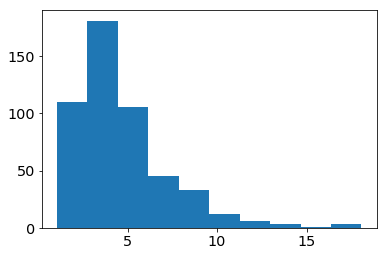

In [278]:
plt.hist(mean_independent_variance)

In [270]:
samples_A = simulate_correlated_data(0.7, size=N)


NameError: name 'N' is not defined

In [3]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def simulate_transcriptomes(n_cells, n_genes):
    
    gene_means = stats.lognorm.rvs(s=1, scale=15, size=n_genes)
    gene_dispersions = stats.lognorm.rvs(s=.7, scale=0.1, size=n_genes) # Larger means more variance
    gene_theta = 1/gene_dispersions

    return gene_means, gene_dispersions, stats.nbinom.rvs(*convert_params(gene_means, gene_theta), size=(n_cells, n_genes))

### Functions for sampling

In [4]:
def capture_sampling(transcriptomes, q, q_sq):
    
    m = q
    v = q_sq - q**2
    alpha = m*(m*(1-m)/v - 1)
    beta = (1-m)*(m*(1-m)/v - 1)
    qs = stats.beta.rvs(alpha, beta, size=transcriptomes.shape[0])
    
    captured_transcriptomes = []
    for i in range(transcriptomes.shape[0]):
        captured_transcriptomes.append(
            stats.hypergeom.rvs(transcriptomes[i, :].sum(), transcriptomes[i, :], np.round(qs[i]*transcriptomes[i, :].sum()).astype(int))
        )
    
    return np.vstack(captured_transcriptomes)


def sequencing_sampling(transcriptomes):
    
    observed_transcriptomes = np.zeros(transcriptomes.shape)
    num_molecules = transcriptomes.sum()
    print(num_molecules)
    
    for i in range(n_cells):
        for j in range(n_genes):
            
            observed_transcriptomes[i, j] = (stats.binom.rvs(n=int(num_reads), p=1/num_molecules, size=transcriptomes[i, j]) > 0).sum()
            
    return observed_transcriptomes
    
#     flattened_transcriptome = transcriptomes.reshape(-1)
#     num_transcripts = flattened_transcriptome.sum()
    
#     molecule_read_counts = stats.multinomial.rvs(
#         num_reads, 
#         [1/num_transcripts for i in range(num_transcripts)])
    
#     molecule_read_indicator = (molecule_read_counts > 0)
    
#     idx_breaks = np.cumsum(flattened_transcriptome)
    
#     final_counts = np.array([x.sum() for x in np.split(molecule_read_indicator, idx_breaks)])[:-1]
    
#     return final_counts.reshape(transcriptomes.shape)


### Define simulation parameters

In [5]:
n_cells = 5000
n_genes = 1000
q = 0.1
noise_level = 0.2049755522580501
q_sq = (noise_level+1)*q**2
num_reads = 2000000
sequencing_capture_efficiency = 1

### Run the simulation

In [6]:
_, _, transcriptome = simulate_transcriptomes(n_cells, n_genes)

In [7]:
captured_transcriptome = capture_sampling(transcriptome, q, q_sq)

In [9]:
#observed_transcriptome = stats.binom.rvs(captured_transcriptome, p=sequencing_capture_efficiency)

### Estimate overall noise parameters

In [10]:
observed_means = observed_transcriptome.mean(axis=0)
observed_vars = observed_transcriptome.var(axis=0)
observed_cv_sq = observed_vars/observed_means**2

Text(0, 0.5, 'log( observed CV^2 )')

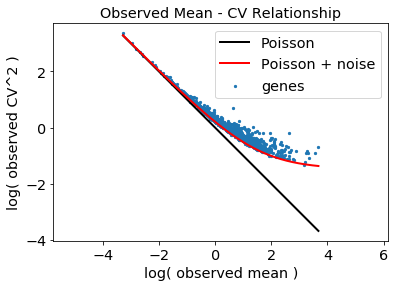

In [11]:
x = observed_means
y = observed_vars
estimated_noise_level = np.percentile(
    (y/x**2 - 1/x)[y > x], 
    q=6)
overall_q = observed_transcriptome.sum()/captured_transcriptome.sum() * q
overall_q_sq = (estimated_noise_level + 1)*overall_q**2

plt.scatter(
    np.log(observed_means),
    np.log(observed_cv_sq),
    s=5
)
bound_x = np.arange(
    np.nanmin(observed_means),
    np.nanmax(observed_means),
    0.01)
bound_y = 1/bound_x + estimated_noise_level

plt.plot(np.log(bound_x), -np.log(bound_x), color='k', lw=2)
plt.plot(np.log(bound_x), np.log(bound_y), lw=2, color='r')
plt.axis('equal');
plt.legend(['Poisson', 'Poisson + noise', 'genes'])
plt.title('Observed Mean - CV Relationship');
plt.xlabel('log( observed mean )')
plt.ylabel('log( observed CV^2 )')

In [14]:
q_sq

0.012049755522580504